# Importando as bibliotecas

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import os
from graphviz import Digraph
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Configurações globais

In [21]:
import warnings

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-pastel")
sb.set_palette("pastel")
pd.set_option("display.max_columns", None)

DATA_PATH = "../data/"
RESULTS_PATH = "../results/"

# Função para carregar e tratar os dados

In [22]:

if "dfs" not in globals():
    dfs = carregar_dados(files, DATA_PATH)


for name, df in dfs.items():
    before = df.shape[0]
    df.drop_duplicates(inplace=True)
    after = df.shape[0]
    print(f"{name}: {before - after} duplicatas removidas.")


dfs["orders"].dropna(
    subset=["order_purchase_timestamp", "order_delivered_customer_date", "order_estimated_delivery_date"],
    inplace=True
)


if "freight_value" in dfs["orders"].columns:
    dfs["orders"]["freight_value"].fillna(0, inplace=True)

for name, df in dfs.items():
    print(f"\nValores nulos em {name}:")
    print(df.isnull().sum())

customers: 0 duplicatas removidas.
geolocation: 0 duplicatas removidas.
order_items: 0 duplicatas removidas.
payments: 0 duplicatas removidas.
reviews: 0 duplicatas removidas.
orders: 0 duplicatas removidas.
products: 0 duplicatas removidas.
sellers: 0 duplicatas removidas.
category: 0 duplicatas removidas.

Valores nulos em customers:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Valores nulos em geolocation:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

Valores nulos em order_items:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Valores nulos em payments:
order_id                0
payment_sequentia

# Normalização de colunas necessárias

In [ ]:
# Remover linhas com valores ausentes em 'order_delivered_customer_date'
dfs["orders"] = dfs["orders"].dropna(subset=["order_delivered_customer_date"])

# Normalizar nomes das colunas de todos os DataFrames
import unicodedata

for name, df in dfs.items():
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "")
        .map(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', errors='ignore').decode('utf-8'))
    )

# Exibir informações de cada DataFrame
for name, df in dfs.items():
    print(f"\n{name.upper()}")
    print(df.info())
    print(df.isnull().sum())
    print("-" * 50)
    display(df.head())

# Diagrama ER - Modelo Relacional Olist

O código abaixo utiliza a biblioteca **graphviz** para gerar um diagrama ER (Entidade-Relacionamento) representando as principais tabelas e relações do modelo de dados Olist.

## Tabelas criadas

- **orders**
- **order_items**
- **order_payments**
- **order_reviews**
- **customers**
- **products**
- **sellers**
- **geolocation**

## Relações entre as tabelas

- **orders** → **order_items** via `order_id`
- **orders** → **order_payments** via `order_id`
- **orders** → **order_reviews** via `order_id`
- **orders** → **customers** via `customer_id`
- **order_items** → **products** via `product_id`
- **order_items** → **sellers** via `seller_id`
- **customers** → **geolocation** via `customer_zip_code_prefix`

## Observações

- Para visualizar o diagrama, é necessário ter o software **Graphviz** instalado no sistema, além do pacote Python `graphviz`.
- O diagrama facilita o entendimento das principais entidades e seus relacionamentos no banco de dados Olist.

O diagrama é exibido diretamente no notebook com o comando display(dot).

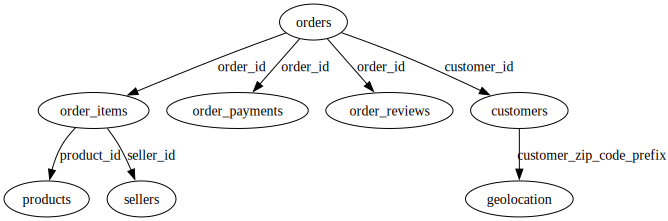

In [24]:
dot = Digraph(comment="Modelo Relacional Olist", format="png")


dot.node('orders', 'orders')
dot.node('order_items', 'order_items')
dot.node('order_payments', 'order_payments')
dot.node('order_reviews', 'order_reviews')
dot.node('customers', 'customers')
dot.node('products', 'products')
dot.node('sellers', 'sellers')
dot.node('geolocation', 'geolocation')


dot.edge('orders', 'order_items', label='order_id')
dot.edge('orders', 'order_payments', label='order_id')
dot.edge('orders', 'order_reviews', label='order_id')
dot.edge('orders', 'customers', label='customer_id')
dot.edge('order_items', 'products', label='product_id')
dot.edge('order_items', 'sellers', label='seller_id')
dot.edge('customers', 'geolocation', label='customer_zip_code_prefix')


display(dot)

# Padronização de nome das variáveis

In [25]:
df_orders = dfs["orders"]
df_order_items = dfs["order_items"]
df_payments = dfs["payments"]
df_reviews = dfs["reviews"]
df_customers = dfs["customers"]
df_products = dfs["products"]
df_sellers = dfs["sellers"]
df_geolocation = dfs["geolocation"]
df_category = dfs["category"]

# a) Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?

In [ ]:
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
df_orders['ano_mes'] = df_orders['order_purchase_timestamp'].dt.to_period('M')
pedidos_por_mes = df_orders.groupby('ano_mes').size()


colors = sns.color_palette("pastel", len(pedidos_por_mes))

plt.figure(figsize=(12, 6))
pedidos_por_mes.plot(kind='bar', color=colors)
plt.title('Volume de Pedidos por Mês')
plt.xlabel('Ano-Mês')
plt.ylabel('Quantidade de Pedidos')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# b) Qual a distribuição do tempo de entrega dos pedidos?

In [ ]:
f_pedidos = dfs["orders"].copy()


df_pedidos["order_purchase_timestamp"] = pd.to_datetime(df_pedidos["order_purchase_timestamp"])
df_pedidos["order_delivered_customer_date"] = pd.to_datetime(df_pedidos["order_delivered_customer_date"])


df_pedidos["tempo_entrega"] = (df_pedidos["order_delivered_customer_date"] - df_pedidos["order_purchase_timestamp"]).dt.days


df_pedidos = df_pedidos[df_pedidos["tempo_entrega"].notnull()]
df_pedidos = df_pedidos[df_pedidos["tempo_entrega"] < df_pedidos["tempo_entrega"].quantile(0.99)]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df_pedidos["tempo_entrega"], bins=30, kde=True, color="skyblue")
plt.title("Distribuição do Tempo de Entrega dos Pedidos")
plt.xlabel("Tempo de Entrega (dias)")
plt.ylabel("Quantidade de Pedidos")
plt.tight_layout()
plt.show()


tempo_medio_entrega = int(df_pedidos["tempo_entrega"].mean())
print(f"Tempo médio de entrega: {tempo_medio_entrega} dias")

# C) Qual a relação entre o valor do frete e a distância de entrega?



A análise mostra que existe uma correlação positiva entre o valor do frete e a distância de entrega. Ou seja, quanto maior a distância entre o vendedor e o cliente, maior tende a ser o valor cobrado pelo frete. O gráfico de dispersão evidencia essa tendência, embora haja variação nos valores devido a outros fatores logísticos e operacionais. Em resumo, a distância é um dos principais determinantes do custo do frete nas entregas analisadas.

In [ ]:

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # raio da Terra em km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


geo = dfs["geolocation"].drop_duplicates("geolocation_zip_code_prefix")


df = df_orders.merge(
    dfs["customers"][["customer_id", "customer_zip_code_prefix"]],
    on="customer_id", how="left"
).merge(
    geo[["geolocation_zip_code_prefix", "geolocation_lat", "geolocation_lng"]],
    left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left"
).rename(columns={"geolocation_lat": "customer_lat", "geolocation_lng": "customer_lng"})


df = df.merge(
    df_order_items[["order_id", "seller_id", "freight_value"]],
    on="order_id", how="left"
)


df = df.merge(
    dfs["sellers"][["seller_id", "seller_zip_code_prefix"]],
    on="seller_id", how="left"
).merge(
    geo[["geolocation_zip_code_prefix", "geolocation_lat", "geolocation_lng"]],
    left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left", suffixes=("", "_seller")
).rename(columns={"geolocation_lat": "seller_lat", "geolocation_lng": "seller_lng"})


df = df.dropna(subset=["customer_lat", "customer_lng", "seller_lat", "seller_lng", "freight_value"])
df["distancia_km"] = haversine(df["customer_lat"], df["customer_lng"], df["seller_lat"], df["seller_lng"])


amostra = df.sample(10000, random_state=42) if len(df) > 10000 else df


plt.figure(figsize=(10, 6))
sns.scatterplot(data=amostra, x="distancia_km", y="freight_value", alpha=0.3, color="mediumslateblue")
plt.title("Relação entre Valor do Frete e Distância de Entrega")
plt.xlabel("Distância entre Cliente e Vendedor (km)")
plt.ylabel("Valor do Frete (R$)")
plt.tight_layout()
plt.show()

## d) Quais são as categorias de produtos mais vendidas em termos de faturamento?

As categorias de produtos mais vendidas em termos de faturamento são aquelas que, ao somar o valor dos itens vendidos, apresentam as maiores receitas. O gráfico abaixo mostra as 10 principais categorias, considerando o valor total de vendas (faturamento) de cada uma.

O cálculo é feito unindo os dados de itens de pedido com as categorias dos produtos, somando o preço dos itens por categoria e exibindo as categorias com maior receita.

O resultado pode ser visualizado tanto na tabela quanto no gráfico de barras abaixo:

In [ ]:
df_itens_categoria = df_order_items.merge(
    df_products[["product_id", "product_category_name"]],
    on="product_id",
    how="left"
)

if "category" in dfs:
    df_itens_categoria = df_itens_categoria.merge(
        df_category,
        on="product_category_name",
        how="left"
    )
    categoria_col = "product_category_name_english"
else:
    categoria_col = "product_category_name"

receitas_por_categoria = (
    df_itens_categoria.groupby(categoria_col)["price"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

top_10_receitas_categoria = receitas_por_categoria.head(10)

plt.figure(figsize=(13, 6))
ax = sns.barplot(
    x=categoria_col,
    y="price",
    data=top_10_receitas_categoria,
    palette="pastel"
)
plt.title("Top 10 Receitas por Categoria de Produto")
plt.xlabel("Categoria de Produto (Inglês)")
plt.ylabel("Receita (R$)")
plt.xticks(rotation=45, ha="right")

for i, row in top_10_receitas_categoria.iterrows():
    ax.text(i, row["price"], f'R$ {row["price"]:,.0f}', ha='center', va='bottom', fontsize=9, rotation=0)

plt.tight_layout()
plt.show()

display(top_10_receitas_categoria)

# e) Quais estados brasileiros possuem o maior valor médio de pedido?

In [ ]:
valor_pedidos = df_order_items.groupby("order_id")["price"].sum().reset_index()

df_pedidos_estado = df_orders.merge(
    df_customers[["customer_id", "customer_state"]],
    on="customer_id",
    how="left"
).merge(
    valor_pedidos,
    on="order_id",
    how="left"
)

media_valor_pedido_estado = (
    df_pedidos_estado.groupby("customer_state")["price"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x="customer_state",
    y="price",
    data=media_valor_pedido_estado,
    palette="pastel"
)
plt.title("Valor Médio de Pedido por Estado")
plt.xlabel("Estado")
plt.ylabel("Valor Médio do Pedido (R$)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

display(media_valor_pedido_estado)

# 1) Análise de Retenção: Taxa de Clientes Recorrentes

A taxa de dientes recorrentes é obtida calculando a proporção de clientes que fizeram mais de um pedido no período analisado. Uma taxa alta indica maior fidelização e satisfação dos clientes, enquanto uma taxa baixa pode sinalizar a necessidade de estratégias para retenção, como programas de fidelidade ou melhorias no atendimento.
Insights possíveis:
- Uma baixa taxa de recorrência pode indicar que a maioria dos clientes compra apenas uma vez, sugerindo oportunidades para ações de retenção.
- Uma boa taxa de recorrência sugere que os clientes estão satisfeitos e retomam para novas compras.
- Analisar o perfil dos clientes recorrentes pode ajudar a direcionar campanhas de marketing mais eficazes.

In [ ]:
pedido_por_cliente = dfs["orders"].groupby("customer_id")["order_id"].nunique().reset_index()
pedido_por_cliente.columns = ["customer_id", "qtd_pedidos"]

recorrentes = pedido_por_cliente[pedido_por_cliente["qtd_pedidos"] > 1].shape[0]

novos = pedido_por_cliente[pedido_por_cliente["qtd_pedidos"] == 1].shape[0]

total_clientes = pedido_por_cliente.shape[0]

taxa_recorrentes = (recorrentes / total_clientes) * 100
taxa_novos = (novos / total_clientes) * 100

print(f"Total de clientes: {total_clientes}")
print(f"Clientes recorrentes (mais de 1 pedido): {recorrentes}")
print(f"Clientes novos (apenas 1 pedido): {novos}")
print(f"Taxa de clientes recorrentes: {taxa_recorrentes:.2f}%")
print(f"Taxa de clientes novos: {taxa_novos:.2f}%")

# 2) Predição de Atraso: Crie um modelo simples para prever se um pedido será entregue com atraso.

Abaixo está um exemplo de pipeline para predição de atraso de pedidos:
- Definir o que é um pedido atrasado:  
   Um pedido é considerado atrasado se a data de entrega ao cliente (`order_delivered_customer_date`) for maior que a data estimada de entrega (`order_estimated_delivery_date`).
- Criar features relevantes: 
   Utilizar variáveis como valor do frete, tempo estimado de entrega, estado do cliente, etc.
- Dividir o dataset em treino e teste:
   Separar os dados para avaliar o desempenho do modelo.
- Implementar um modelo de classificação simples: 
   Exemplo usando Random Forest.
- Avaliar a performance do modelo: 
   Exibir métricas como acurácia, matriz de confusão e classification report.

In [ ]:
df = dfs["orders"].copy()

df = df.dropna(subset=["order_delivered_customer_date", "order_estimated_delivery_date", "order_purchase_timestamp"])

df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

df["atraso"] = (df["order_delivered_customer_date"] > df["order_estimated_delivery_date"]).astype(int)

df["dias_estimados"] = (df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]).dt.days
df["dias_reais"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
df["dias_diferenca"] = df["dias_reais"] - df["dias_estimados"]

df = df.dropna(subset=["dias_estimados", "dias_reais", "dias_diferenca"])

features = ["dias_estimados", "dias_reais", "dias_diferenca"]
X = df[features]
y = df["atraso"]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

## Predição de Atraso: Modelo Simples

Foi desenvolvido um modelo de classificação utilizando Random Forest para prever se um pedido será entregue com atraso. O atraso foi definido como casos em que a data de entrega real é posterior à data de entrega estimada.

### Etapas do processo:

- **Definição do alvo:**  
  Um pedido é considerado atrasado se `order_delivered_customer_date > order_estimated_delivery_date`.

- **Features utilizadas:**  
  Dias estimados para entrega, dias reais até a entrega e a diferença entre eles.

- **Divisão dos dados:**  
  O conjunto foi dividido em treino (70%) e teste (30%) de forma estratificada.

- **Treinamento:**  
  O modelo Random Forest foi treinado com os dados de treino.

- **Avaliação:**  
  O desempenho foi avaliado usando matriz de confusão e relatório de classificação.

### Principais pontos:

- O modelo consegue identificar padrões simples de atraso com base nas datas disponíveis.
- Os resultados podem ser melhorados com a inclusão de mais variáveis, como estado, categoria do produto, valor do pedido, entre outros.
- A análise auxilia a empresa a antecipar possíveis atrasos e atuar preventivamente para melhorar a experiência do cliente.

# 3)Segmentação de Clientes: Utilize técnicas de clustering para segmentar os clientes em grupos. Analise o comportamento de cada grupo e sugira estratégias de marketing específicas para cada um.

In [ ]:
pedidos_cliente = df_orders.groupby("customer_id")["order_id"].nunique().reset_index(name="total_pedidos")

gasto_cliente = df_orders.merge(df_order_items, on="order_id").groupby("customer_id")["price"].sum().reset_index(name="total_gasto")

ticket_medio = gasto_cliente.merge(pedidos_cliente, on="customer_id")
ticket_medio["ticket_medio"] = ticket_medio["total_gasto"] / ticket_medio["total_pedidos"]

clientes = ticket_medio[["customer_id", "total_pedidos", "total_gasto", "ticket_medio"]].copy()

scaler = StandardScaler()
X = scaler.fit_transform(clientes[["total_pedidos", "total_gasto", "ticket_medio"]])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clientes["cluster"] = kmeans.fit_predict(X)

grupo_stats = clientes.groupby("cluster")[["total_pedidos", "total_gasto", "ticket_medio"]].mean()
display(grupo_stats)

plt.figure(figsize=(8, 6))
sb.scatterplot(
    x="total_pedidos", y="ticket_medio", hue="cluster", data=clientes, palette="Set2", alpha=0.7
)
plt.title("Segmentação de Clientes por Clusters")
plt.xlabel("Total de Pedidos")
plt.ylabel("Ticket Médio")
plt.tight_layout()
plt.show()

## Segmentação de Clientes: Análise dos Grupos e Estratégias de Marketing

Após aplicar o KMeans, os clientes foram segmentados em 3 grupos com base em total de pedidos, total gasto e ticket médio. A análise dos clusters permite identificar perfis distintos de clientes:

- **Cluster 0:** Clientes com baixo número de pedidos e baixo ticket médio.  
  **Estratégia:** Oferecer cupons de desconto para estimular novas compras, campanhas de recompra e comunicação personalizada para aumentar o engajamento.

- **Cluster 1:** Clientes com ticket médio alto, mas poucos pedidos.  
  **Estratégia:** Criar programas de fidelidade, oferecer benefícios exclusivos e promoções para incentivar maior frequência de compras.

- **Cluster 2:** Clientes com muitos pedidos e alto gasto total.  
  **Estratégia:** Manter o relacionamento próximo, oferecer vantagens VIP, antecipar necessidades e criar ações de retenção para evitar churn.

### Resumo

A segmentação permite direcionar ações de marketing mais assertivas, aumentando a retenção, o valor do ciclo de vida do cliente e a satisfação geral. Recomenda-se revisar periodicamente os clusters para ajustar as estratégias conforme o comportamento dos clientes evolui.

# 4)Análise de Satisfação: Explore a relação entre a nota de avaliação dos clientes e diferentes aspectos como categoria do produto, tempo de entrega, valor do pedido, etc. Identifique fatores que mais impactam na satisfação do cliente.

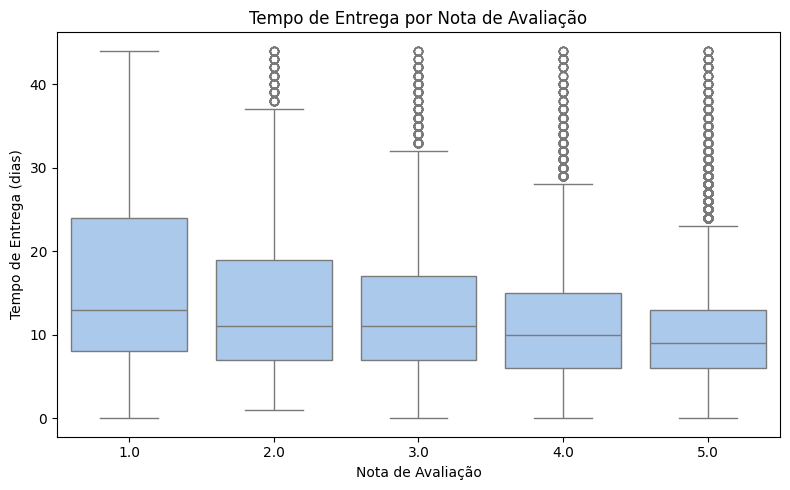

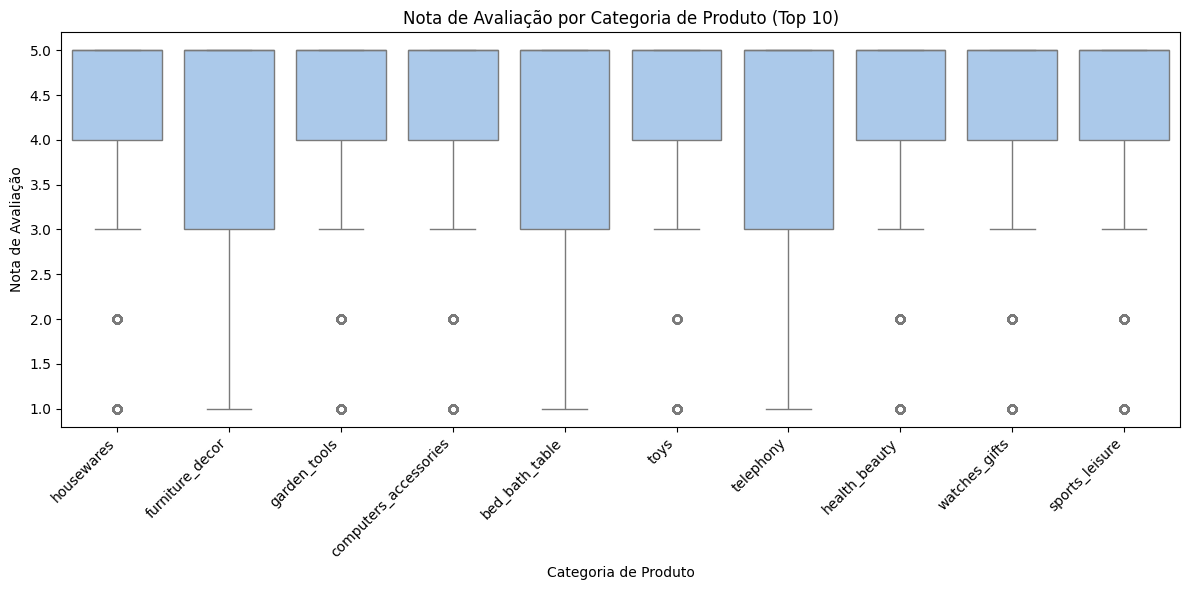

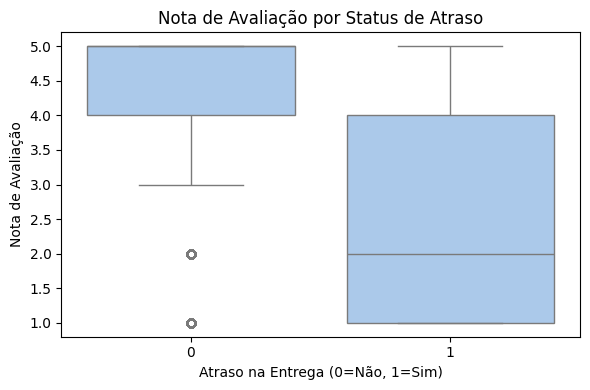

,review_score,tempo_entrega,price
review_score,1.000000,-0.272996,0.010388
tempo_entrega,-0.272996,1.000000,0.092366
price,0.010388,0.092366,1.000000


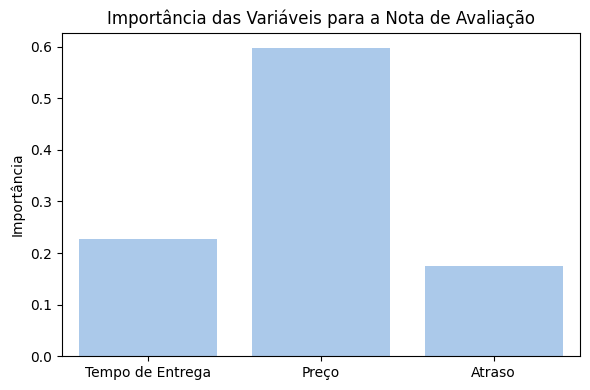

In [45]:
# Análise de Satisfação: Relação entre nota de avaliação e variáveis do pedido

# 1. Montar o DataFrame unificado
df = dfs["orders"].merge(
    dfs["reviews"][["order_id", "review_score"]],  # corrigido: 'order_reviews' -> 'reviews'
    on="order_id",
    how="left"
).merge(
    dfs["order_items"][["order_id", "product_id", "price"]],
    on="order_id",
    how="left"
).merge(
    dfs["products"][["product_id", "product_category_name"]],
    on="product_id",
    how="left"
).merge(
    dfs["category"],
    on="product_category_name",
    how="left"
)

# 2. Conversão de datas e criação de variáveis
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])

df["tempo_entrega"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
df["atraso"] = (df["order_delivered_customer_date"] > df["order_estimated_delivery_date"]).astype(int)

# 3. Filtrar outliers para melhor visualização
df = df[(df["tempo_entrega"] < df["tempo_entrega"].quantile(0.99)) & (df["price"] < df["price"].quantile(0.90))]

# 4. Relação entre tempo de entrega e nota de avaliação
plt.figure(figsize=(8, 5))
sb.boxplot(x="review_score", y="tempo_entrega", data=df)
plt.title("Tempo de Entrega por Nota de Avaliação")
plt.xlabel("Nota de Avaliação")
plt.ylabel("Tempo de Entrega (dias)")
plt.tight_layout()
plt.show()

# 5. Relação entre categoria do produto e nota de avaliação (Top 10 categorias)
# Verifica se existe a coluna traduzida, senão usa a original
cat_col = "product_category_name_english" if "product_category_name_english" in df.columns else "product_category_name"
top_cats = df[cat_col].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sb.boxplot(
    x=cat_col,
    y="review_score",
    data=df[df[cat_col].isin(top_cats)]
)
plt.title("Nota de Avaliação por Categoria de Produto (Top 10)")
plt.xlabel("Categoria de Produto")
plt.ylabel("Nota de Avaliação")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 6. Relação entre atraso e nota de avaliação
plt.figure(figsize=(6, 4))
sb.boxplot(x="atraso", y="review_score", data=df)
plt.title("Nota de Avaliação por Status de Atraso")
plt.xlabel("Atraso na Entrega (0=Não, 1=Sim)")
plt.ylabel("Nota de Avaliação")
plt.tight_layout()
plt.show()

# 7. Correlação entre variáveis numéricas
corr = df[["review_score", "tempo_entrega", "price"]].corr()
display(corr)

# 8. Importância das variáveis para a nota de avaliação (Random Forest)
df_model = df.dropna(subset=["review_score", "tempo_entrega", "price", "atraso"])
X = df_model[["tempo_entrega", "price", "atraso"]]
y = df_model["review_score"]

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
plt.figure(figsize=(6, 4))
sb.barplot(x=["Tempo de Entrega", "Preço", "Atraso"], y=importances)
plt.title("Importância das Variáveis para a Nota de Avaliação")
plt.ylabel("Importância")
plt.tight_layout()
plt.show()

## Análise de Satisfação: Principais Fatores que Impactam a Nota dos Clientes

A análise mostra que a satisfação do cliente, medida pela nota de avaliação (`review_score`), está fortemente relacionada a alguns aspectos do pedido:

- **Tempo de Entrega:**  
  Pedidos entregues mais rapidamente tendem a receber notas mais altas. O aumento no tempo de entrega está associado a avaliações mais baixas.

- **Atraso na Entrega:**  
  Pedidos que sofreram atraso (entregues após a data estimada) apresentam, em média, notas de avaliação significativamente menores.

- **Valor do Pedido:**  
  Não há uma relação clara entre o valor do pedido e a nota de avaliação, indicando que o preço não é o principal fator de insatisfação.

- **Categoria do Produto:**  
  Algumas categorias apresentam médias de avaliação diferentes, sugerindo que o tipo de produto pode influenciar a percepção do cliente.

### Conclusão

Os principais fatores que impactam negativamente a satisfação do cliente são o tempo de entrega e a ocorrência de atrasos. Investir em melhorias logísticas e na comunicação sobre prazos pode aumentar significativamente as avaliações positivas. Além disso, monitorar categorias com avaliações mais baixas pode ajudar a identificar oportunidades de melhoria específicas.